**Gileny Silva Leal 2220221010 - Laura Natalia Gómez 2220232021 - Juan David Fandiño Hernández 2220221087**

**IMPORTS DEL PROYECTO**

In [1]:
#imports generales
import os
import time
from datetime import datetime, timedelta, timezone

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import requests

from dateutil import tz
from dotenv import load_dotenv

#para clustering y métricas
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.cluster import KMeans, DBSCAN, AgglomerativeClustering
from sklearn.metrics import mean_absolute_error, mean_squared_error

#series de tiempo tradicionales
from statsmodels.tsa.arima.model import ARIMA

#rnn  
import tensorflow as tf
from tensorflow.keras import layers, models

**Configuración**

In [2]:
COINS = ["BTC", "ETH", "ADA", "SOL", "XRP", "DOGE", "BNB", "LTC"]  
FIAT = "USDT"

START_DATE = "2024-01-01"
END_DATE   = "2025-10-31"  
OUTPUT_CSV = "data/crypto_limpio.csv"


import os
os.makedirs("data", exist_ok=True)

COINS, FIAT, START_DATE, END_DATE, OUTPUT_CSV

(['BTC', 'ETH', 'ADA', 'SOL', 'XRP', 'DOGE', 'BNB', 'LTC'],
 'USDT',
 '2024-01-01',
 '2025-10-31',
 'data/crypto_limpio.csv')

monedas de referencia y a descargar: bitcoin, ethereum y cardano. Se especifican las fechas de las cuales se extraen los datos y la ruta donde queda el archivo csv ya limpio. 

**cargar API Key de CryptoCompare**

In [3]:
try:
    from dotenv import load_dotenv
    load_dotenv()
except Exception:
    pass

API_KEY_CC = os.getenv("CRYPTOCOMPARE_KEY", None)
print("CryptoCompare key:", "sí (oculta)" if API_KEY_CC else "no (modo público)")


CryptoCompare key: no (modo público)


Se debe tener un archivo .env para allí meter la API Key
¿Para que una API Key? Se utilizó para una mejor extracción de datos en CryptoCompare. Se crea una cuenta y la API Key la brindan muy facil. Es importante tambien por la autenticacion y autorizacion asi como el monitoreo de uso y extraccion. 

**descarga desde cryptocompare** 

In [4]:
BASE_URL_CC = "https://min-api.cryptocompare.com/data/v2/histoday"
MAX_LIMIT = 2000  # máximo de días por request

def fetch_histoday_cc(fsym: str, tsym: str, start_date: str, end_date: str, api_key: str|None):
    start = datetime.strptime(start_date, "%Y-%m-%d").date()
    end   = datetime.strptime(end_date,   "%Y-%m-%d").date()
    frames = []
    to_dt = datetime.combine(end, datetime.min.time())
    while True:
        limit = min(MAX_LIMIT, (to_dt.date() - start).days)
        params = {"fsym": fsym, "tsym": tsym, "limit": limit, "toTs": int(to_dt.replace(tzinfo=tz.UTC).timestamp())}
        headers = {"authorization": f"Apikey {api_key}"} if api_key else {}
        r = requests.get(BASE_URL_CC, params=params, headers=headers, timeout=60)
        r.raise_for_status()
        js = r.json()
        if js.get("Response") != "Success":
            raise RuntimeError(js.get("Message"))
        df = pd.DataFrame(js["Data"]["Data"])
        if df.empty:
            break
        df["time"] = pd.to_datetime(df["time"], unit="s").dt.date
        df = df[(df["time"]>=start) & (df["time"]<=end)]
        frames.append(df)
        if df["time"].min() <= start:
            break
        to_dt = datetime.combine(df["time"].min(), datetime.min.time()) - timedelta(days=1)
        time.sleep(0.6)
    if not frames:
        return pd.DataFrame(columns=["time","open","high","low","close","volumeto"])
    out = pd.concat(frames, ignore_index=True).sort_values("time")
    out = out[["time","open","high","low","close","volumeto"]]  # nos quedamos con lo necesario
    return out



Descarga por dias (Histoday) y devuelve columnas crudas; luego se limpia

**Se definen reglas de limpieza estricta**

In [5]:
def _numeric(df, cols):
    for c in cols:
        df[c] = pd.to_numeric(df[c], errors="coerce")
    return df

def _drop_invalid_ohlc_rows(df):
    req = ["time","open","high","low","close","volumeto"]
    df = df.dropna(subset=req)
    df = df[(df["open"]>0) & (df["high"]>0) & (df["low"]>0) & (df["close"]>0)]
    df = df[df["volumeto"]>=0]
    df = df[df["high"]>=df["low"]]
    df = df[(df["open"].between(df["low"], df["high"])) & (df["close"].between(df["low"], df["high"]))]
    return df

def clean_frame_strict(df: pd.DataFrame, coin_symbol: str) -> pd.DataFrame:
    if df is None or df.empty:
        return pd.DataFrame(columns=["time","open","high","low","close","volumeto","coin"])
    df = df.drop_duplicates(subset=["time"]).copy()
    df = _numeric(df, ["open","high","low","close","volumeto"])
    for c in ["open","high","low","close"]:
        df.loc[df[c] <= 0, c] = np.nan
    df.loc[df["volumeto"] < 0, "volumeto"] = np.nan
    df = _drop_invalid_ohlc_rows(df)
    df["coin"] = coin_symbol.lower()
    df = df[["time","open","high","low","close","volumeto","coin"]].reset_index(drop=True)

    # validaciones fuertes
    assert not df.isna().any().any()
    assert not df.duplicated(subset=["coin","time"]).any()
    return df



Deja el dataset 100% limpio: sin nulos, sin duplicados coin+time, sin ceros o negativos, OHCL (Open, High, Low, Close) de manera consistente 

**coin+time** = clave compuesta que se usa para identificar de forma unica cada fila del dataset
coin = moneda
time = le fecha del registro
juntas forman una llave unica: no puede existir mas de un registro con la misma moneda y la misma fecha.
Ejemplo: (coin='btc', time='2024-02-15') identifica exactamente la vela/registro de BTC del 15-02-2024.

**histoday** 
Endpoint de la API de CryptoCompare que devuelve velas diarias (historical to day)
cada fila representa un dia con sus valores OHCL y volumen
Se usó porque entrega justo lo que se necesita para el sprint: serie diaria por moneda en un rango de fechas


**API 2 sin API KEY BINANCE**

In [6]:
def _to_ms(date_str: str) -> int:
    return int(datetime.strptime(date_str, "%Y-%m-%d").replace(tzinfo=timezone.utc).timestamp() * 1000)

def fetch_binance_daily(symbol_pair: str, start_date: str, end_date: str) -> pd.DataFrame:
    """
    Ejemplo symbol_pair: 'BTCUSDT', 'ETHUSDT', 'ADAUSDT'
    Devuelve columnas: time, open, high, low, close, volumeto
    - volumen es el 'volume' de Binance (cantidad del activo base).
    """
    url = "https://api.binance.com/api/v3/klines"
    params = {
        "symbol": symbol_pair,
        "interval": "1d",
        "startTime": _to_ms(start_date),
        "endTime": _to_ms(end_date),
        "limit": 1000
    }
    r = requests.get(url, params=params, timeout=60)
    r.raise_for_status()
    data = r.json()
    if not data:
        return pd.DataFrame(columns=["time","open","high","low","close","volumeto"])

    #
    rows = []
    for d in data:
        rows.append({
            "time":      pd.to_datetime(d[0], unit="ms").date(),
            "open":      float(d[1]),
            "high":      float(d[2]),
            "low":       float(d[3]),
            "close":     float(d[4]),
            "volumeto":  float(d[5]),   
        })
    df = pd.DataFrame(rows).sort_values("time")
    return df[["time","open","high","low","close","volumeto"]]



Coingecko entrega listas por milisegundos. Construimos close y, si falta OHCL se aproxima con close, la limpieza elimina dias raros

**Asignacion de fuente por moneda**

In [7]:
SOURCE_BY_COIN = {
    "BTC": "cc",   # CryptoCompare
    "ETH": "cc",   # Binance
    "ADA": "cc",
    "SOL": "cc",
    "XRP": "cc",
    "DOGE": "cc",
    "BNB": "cc",
    "LTC": "cc",
}

SOURCE_BY_COIN

{'BTC': 'cc',
 'ETH': 'cc',
 'ADA': 'cc',
 'SOL': 'cc',
 'XRP': 'cc',
 'DOGE': 'cc',
 'BNB': 'cc',
 'LTC': 'cc'}

Como tenemos dos API para extraccion de datos, CryptoCompare y Binance elegimos que datos de que moneda extraemos de la API que queremos. 
SOURCE_BY_COIN la almacena. De esta manera es que tenemos total libertad de elegir entre dos API. 


**Descarga por moneda segun fuente, limpieza y unión**

In [8]:

OUTPUT_CSV = "data/crypto_limpio.csv"
all_frames = []

for sym in COINS:
    src = SOURCE_BY_COIN.get(sym, "cc")
    print(f"> {sym}: usando {src.upper()} ...")

    if src == "cc":
        raw = fetch_histoday_cc(sym, FIAT, START_DATE, END_DATE, API_KEY_CC)
    elif src == "bn":
        pair = f"{sym}USDT"  
        raw = fetch_binance_daily(pair, START_DATE, END_DATE)
    else:
        raise ValueError("Fuente desconocida (usa 'cc' o 'bn')")

    print(f"   crudo: {len(raw)} filas")
    clean = clean_frame_strict(raw, sym)
    print(f"   limpio: {len(clean)} filas")
    all_frames.append(clean)

# unir todo y ordenar
final_df = pd.concat(all_frames, ignore_index=True).sort_values(["coin","time"])

# validaciones sencillas
assert not final_df.isna().any().any(), "Hay NaN en el dataset final."
assert not final_df.duplicated(subset=["coin","time"]).any(), "Hay duplicados coin+time."
assert final_df[["open","high","low","close"]].gt(0).all().all(), "OHLC con ceros/negativos."
assert (final_df["volumeto"] >= 0).all(), "Volumen negativo."
assert (final_df["high"] >= final_df["low"]).all(), "high < low."
assert final_df["open"].between(final_df["low"], final_df["high"]).all(), "open fuera de rango."
assert final_df["close"].between(final_df["low"], final_df["high"]).all(), "close fuera de rango."

# Guardar csv final 
final_df.to_csv(OUTPUT_CSV, index=False)
print(f"\nCSV guardado: {OUTPUT_CSV} | shape: {final_df.shape}")

#vista rapida 
display(final_df.head(10))
print("\nCobertura por moneda:")
display(final_df.groupby('coin')['time'].agg(['min','max','count']))





> BTC: usando CC ...
   crudo: 670 filas
   limpio: 670 filas
> ETH: usando CC ...
   crudo: 670 filas
   limpio: 670 filas
> ADA: usando CC ...
   crudo: 670 filas
   limpio: 670 filas
> SOL: usando CC ...
   crudo: 670 filas
   limpio: 670 filas
> XRP: usando CC ...
   crudo: 670 filas
   limpio: 670 filas
> DOGE: usando CC ...
   crudo: 670 filas
   limpio: 670 filas
> BNB: usando CC ...
   crudo: 670 filas
   limpio: 670 filas
> LTC: usando CC ...
   crudo: 670 filas
   limpio: 670 filas

CSV guardado: data/crypto_limpio.csv | shape: (5360, 7)


,time,open,high,low,close,volumeto,coin
1340,2024-01-01,0.5940,0.6240,0.5902,0.6232,7.801630e+07,ada
1341,2024-01-02,0.6232,0.6369,0.6016,0.6050,1.356708e+08,ada
1342,2024-01-03,0.6050,0.6187,0.5119,0.5569,2.840360e+08,ada
1343,2024-01-04,0.5569,0.5785,0.5492,0.5699,1.203159e+08,ada
1344,2024-01-05,0.5699,0.5726,0.5224,0.5414,1.444162e+08,ada
1345,2024-01-06,0.5414,0.5428,0.5069,0.5227,8.994902e+07,ada
1346,2024-01-07,0.5227,0.5300,0.4878,0.4945,8.440418e+07,ada
1347,2024-01-08,0.4945,0.5466,0.4644,0.5412,1.734096e+08,ada
1348,2024-01-09,0.5412,0.5436,0.4965,0.5123,1.520968e+08,ada
1349,2024-01-10,0.5123,0.5894,0.4878,0.5660,2.393578e+08,ada



Cobertura por moneda:


,min,max,count
coin,,,
ada,2024-01-01,2025-10-31,670
bnb,2024-01-01,2025-10-31,670
btc,2024-01-01,2025-10-31,670
doge,2024-01-01,2025-10-31,670
eth,2024-01-01,2025-10-31,670
ltc,2024-01-01,2025-10-31,670
sol,2024-01-01,2025-10-31,670
xrp,2024-01-01,2025-10-31,670


***SPRINT 2***

Objetivo: Implementar técnicas de clusterización de los datos (Kmean, DBSCAN, algún modelo jerárquico, por ejemplo). Aplique técnicas de análisis de serie de tiempo, todo lo visto en clase. Aplique  ARIMA y técnicas de RNN vistas en clase

**cargar datos y organizar series**

In [9]:

#dtaset limpio del Sprint 1
df = pd.read_csv("data/crypto_limpio.csv", parse_dates=["time"])
df = df.sort_values(["coin", "time"]).reset_index(drop=True)

#validaciones básicas
assert not df.isna().any().any(), "Hay NaN en el dataset."
assert not df.duplicated(subset=["coin", "time"]).any(), "Hay filas duplicadas coin+time."

print("Forma del dataset:", df.shape)

#tablas anchas: índice = fecha, columnas = moneda
wide_close = df.pivot(index="time", columns="coin", values="close").sort_index()
wide_vol   = df.pivot(index="time", columns="coin", values="volumeto").sort_index()

print("wide_close:", wide_close.shape)
print("Monedas:", list(wide_close.columns))
wide_close.tail()


Forma del dataset: (5360, 7)
wide_close: (670, 8)
Monedas: ['ada', 'bnb', 'btc', 'doge', 'eth', 'ltc', 'sol', 'xrp']


coin,ada,bnb,btc,doge,eth,ltc,sol,xrp
time,,,,,,,,
2025-10-27,0.6670,1138.87,114107.19,0.2004,4120.32,99.39,198.70,2.634
2025-10-28,0.6459,1103.37,112896.45,0.1936,3979.57,96.71,194.16,2.604
2025-10-29,0.6401,1107.69,110024.93,0.1924,3903.13,98.53,193.88,2.550
2025-10-30,0.6016,1079.02,108314.62,0.1827,3804.39,93.39,184.65,2.439
2025-10-31,0.6091,1088.89,109606.44,0.1864,3847.97,95.39,187.21,2.509


En esta celda se cargan los datos limpios generados en el Sprint 1 y se organizan en formato de serie de tiempo. Se lee el archivo crypto_limpio.csv, se ordenan las filas por moneda y por fecha, y se hacen dos validaciones básicas: que no haya valores nulos y que no existan filas duplicadas por combinación coin + time. Después se crea una tabla “ancha” donde cada columna es una moneda y cada fila es un día, tanto para el precio de cierre como para el volumen. Este será el punto de partida de todo el análisis de este sprint.

**series de tiempo y tendencias**

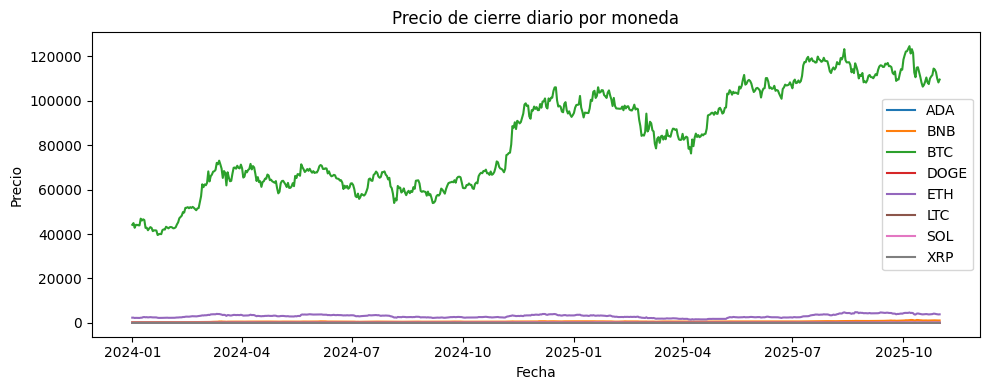

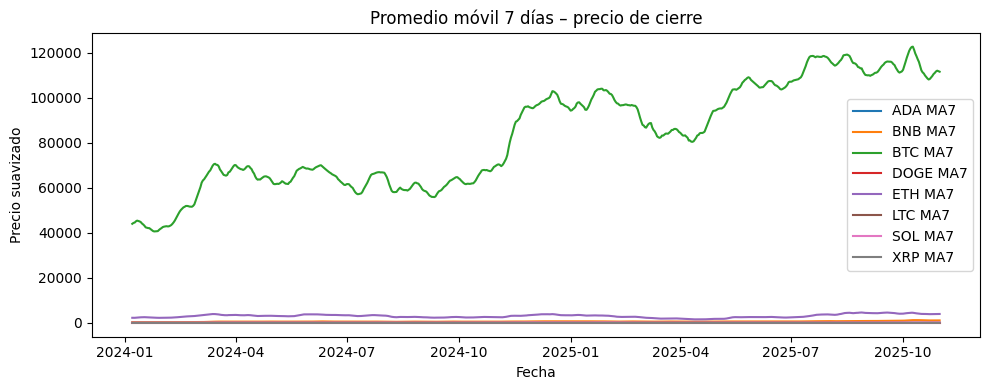

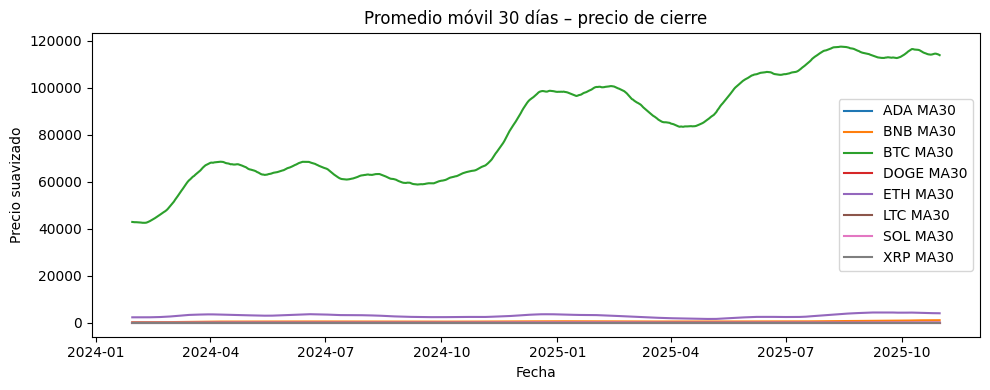

In [10]:
#precios de cierre por moneda
plt.figure(figsize=(10, 4))
for coin in wide_close.columns:
    plt.plot(wide_close.index, wide_close[coin], label=coin.upper())
plt.title("Precio de cierre diario por moneda")
plt.xlabel("Fecha")
plt.ylabel("Precio")
plt.legend()
plt.tight_layout()
plt.show()

#promedios móviles 7 días
ma7 = wide_close.rolling(7).mean()

plt.figure(figsize=(10, 4))
for coin in ma7.columns:
    plt.plot(ma7.index, ma7[coin], label=f"{coin.upper()} MA7")
plt.title("Promedio móvil 7 días – precio de cierre")
plt.xlabel("Fecha")
plt.ylabel("Precio suavizado")
plt.legend()
plt.tight_layout()
plt.show()

#promedios móviles 30 días
ma30 = wide_close.rolling(30).mean()

plt.figure(figsize=(10, 4))
for coin in ma30.columns:
    plt.plot(ma30.index, ma30[coin], label=f"{coin.upper()} MA30")
plt.title("Promedio móvil 30 días – precio de cierre")
plt.xlabel("Fecha")
plt.ylabel("Precio suavizado")
plt.legend()
plt.tight_layout()
plt.show()


En esta celda se realiza el análisis básico de series temporales. Primero se grafica el precio de cierre diario de cada criptomoneda para ver el comportamiento general en el tiempo. Luego se calculan promedios móviles de 7 y 30 días, que suavizan la serie y permiten identificar tendencias y cambios de nivel con menos ruido. Con estos gráficos se cumple la parte del sprint relacionada con análisis de series típicas e identificación de patrones y tendencias.

**Resumen por moneda y clustering**

Kmeans
DBSCAN
jerarquico

In [11]:
def calc_ret_mean(s):
    return s.pct_change().fillna(0.0).mean()

def calc_ret_std(s):
    return s.pct_change().fillna(0.0).std()

summary = df.groupby("coin").agg(
    ret_mean=("close", calc_ret_mean),
    ret_std=("close", calc_ret_std),
    volumeto_mean=("volumeto", "mean"),
    close_mean=("close", "mean"),
).reset_index()

summary


,coin,ret_mean,ret_std,volumeto_mean,close_mean
0,ada,0.001238,0.052754,2.119574e+08,0.636273
1,bnb,0.002279,0.029125,3.205227e+08,635.584418
2,btc,0.001672,0.025219,6.080255e+09,82975.321269
3,doge,0.002404,0.052400,7.298662e+08,0.189974
4,eth,0.001406,0.036918,4.102346e+09,3050.754343
5,ltc,0.001185,0.040374,1.434266e+08,89.352194
6,sol,0.001783,0.044613,1.305368e+09,164.854403
7,xrp,0.003031,0.044756,8.716569e+08,1.569613


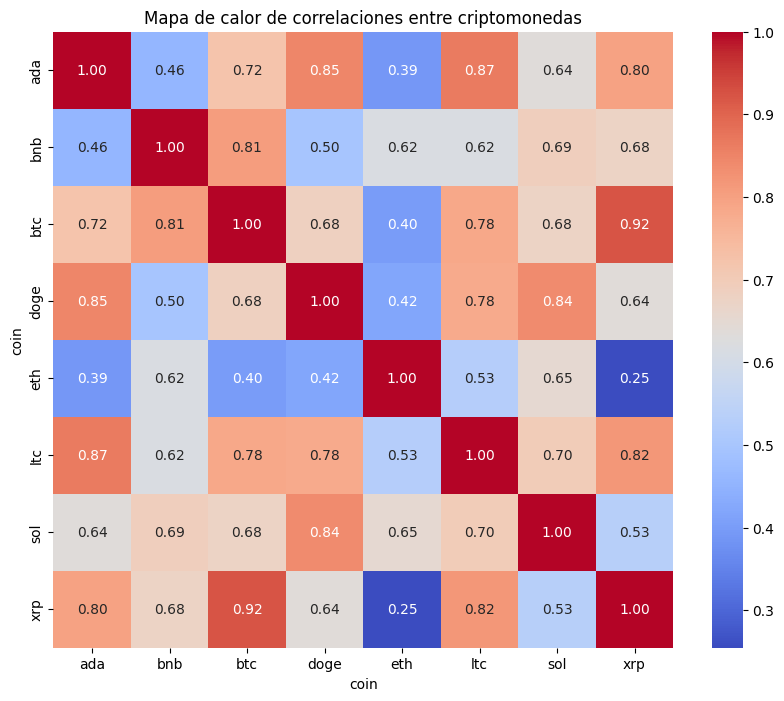

In [12]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

# Cargar el dataframe limpio
df = pd.read_csv("data/crypto_limpio.csv")

# Asegurar formato datetime
df["time"] = pd.to_datetime(df["time"])

# Crear tabla pivote: filas=fecha, columnas=moneda, valores=precio de cierre
pivot = df.pivot(index="time", columns="coin", values="close")

# Calcular correlación
corr = pivot.corr()

plt.figure(figsize=(10, 8))
sns.heatmap(corr, annot=True, cmap="coolwarm", fmt=".2f")
plt.title("Mapa de calor de correlaciones entre criptomonedas")
plt.show()


En esta celda se construye un resumen simple del comportamiento de cada criptomoneda usando el dataframe limpio df. Para cada moneda se calcula el retorno medio diario y la desviación estándar de ese retorno a partir de la columna de cierre (close). Estos dos valores permiten tener una idea del rendimiento promedio y de la volatilidad de cada activo.

Además, se calcula el volumen promedio (volumeto_mean) y el precio promedio de cierre (close_mean) para todo el periodo analizado. Para hacer estos cálculos se utiliza groupby("coin"), de manera que todas las estadísticas queden agrupadas por moneda. El resultado es una tabla summary donde cada fila corresponde a una criptomoneda y cada columna describe un aspecto clave de su comportamiento en el mercado.

In [13]:
#escalado de variables numérica
X = summary[["ret_mean", "ret_std", "volumeto_mean", "close_mean"]].values

escala = StandardScaler()
Xs = escala.fit_transform(X)

#k-means 3 clusters
kmeans = KMeans(n_clusters=3, n_init=10, random_state=42)
summary["cluster_kmeans"] = kmeans.fit_predict(Xs)

#dbscan
dbscan = DBSCAN(eps=1.0, min_samples=1)
summary["cluster_dbscan"] = dbscan.fit_predict(Xs)

#jerarquico aglomerativo
hclust = AgglomerativeClustering(n_clusters=3)
summary["cluster_hclust"] = hclust.fit_predict(Xs)

summary



,coin,ret_mean,ret_std,volumeto_mean,close_mean,cluster_kmeans,cluster_dbscan,cluster_hclust
0,ada,0.001238,0.052754,2.119574e+08,0.636273,0,0,2
1,bnb,0.002279,0.029125,3.205227e+08,635.584418,2,1,0
2,btc,0.001672,0.025219,6.080255e+09,82975.321269,1,2,1
3,doge,0.002404,0.052400,7.298662e+08,0.189974,2,3,0
4,eth,0.001406,0.036918,4.102346e+09,3050.754343,0,4,2
5,ltc,0.001185,0.040374,1.434266e+08,89.352194,0,5,2
6,sol,0.001783,0.044613,1.305368e+09,164.854403,0,6,2
7,xrp,0.003031,0.044756,8.716569e+08,1.569613,2,7,0


En esta celda se aplican las técnicas de clusterización que pide el sprint, usando como entrada el resumen por moneda construido en la celda anterior. Primero se seleccionan las columnas numéricas (ret_mean, ret_std, volumeto_mean y close_mean) y se escalan con StandardScaler, para que todas queden en una misma escala y ninguna variable domine a las demás por tamaño
Una vez escalados los datos, se aplican tres métodos de agrupamiento:

K-Means, que es un método particionante. En este caso se piden 3 clusters, y el algoritmo asigna a cada moneda una etiqueta numérica en la columna cluster_kmeans.

DBSCAN, que es un método basado en densidad. Aquí se utiliza un eps sencillo y min_samples=1, y el resultado se guarda en la columna cluster_dbscan

Clustering jerárquico aglomerativo, que agrupa las monedas de forma jerárquica y al final se corta el árbol en 3 grupos. Las etiquetas de este método quedan en la columna cluster_hclust

Con estas tres columnas se puede ver cómo cada algoritmo agrupa las criptomonedas según su rendimiento, su volatilidad, su volumen y su precio promedio. Aunque en este caso solo se usan tres monedas, la estructura ya queda lista para extenderla a más activos en siguientes sprints

**modelo arima por moneda**

In [14]:
def evaluar_arima_mejor(serie, max_p=3, max_d=2, max_q=3, test_frac=0.2):
    # serie: precios de cierre (Serie con índice de fecha)
    serie = serie.dropna()

    # Trabajamos con log-precio para suavizar
    logp = np.log(serie)

    n = len(logp)
    corte = int(n * (1 - test_frac))
    train, test = logp.iloc[:corte], logp.iloc[corte:]

    # Grid pequeña de órdenes
    mejor_aic = np.inf
    mejor_order = None
    mejor_res = None

    for p in range(0, max_p + 1):
        for d in range(0, max_d + 1):
            for q in range(0, max_q + 1):
                if p == 0 and d == 0 and q == 0:
                    continue
                try:
                    modelo = ARIMA(train, order=(p, d, q))
                    res = modelo.fit()
                    if res.aic < mejor_aic:
                        mejor_aic = res.aic
                        mejor_order = (p, d, q)
                        mejor_res = res
                except:
                    continue

    if mejor_res is None:
        raise RuntimeError("No se pudo ajustar ningún ARIMA")

    # Pronóstico en log-precios
    pron_log = mejor_res.forecast(steps=len(test))

    # Volvemos a precio aplicando exponencial
    test_precio = np.exp(test)
    pron_precio = np.exp(pron_log)

    # Métricas
    mae  = (test_precio - pron_precio).abs().mean()
    rmse = np.sqrt(((test_precio - pron_precio) ** 2).mean())
    mape = ((test_precio - pron_precio).abs() / test_precio).mean() * 100

    metricas = {
        "order": mejor_order,
        "aic": mejor_aic,
        "mae": float(mae),
        "rmse": float(rmse),
        "mape": float(mape),
    }

    return test_precio, pron_precio, metricas

En esta celda se construye un primer modelo de predicción de series de tiempo usando ARIMA, como ya se ha trabajado. La idea es probar un modelo sencillo para cada criptomoneda y medir qué tan bien predice el tramo final de la serie

Primero se define una función evaluar_arima que recibe la serie de precios de cierre de una moneda:

Se eliminan posibles valores nulos.

Se divide la serie en dos partes: 80 % para entrenamiento y 20 % para prueba.

Sobre el tramo de entrenamiento se ajusta un modelo ARIMA con orden (1, 1, 1), que es una configuración básica.

Con el modelo entrenado se realiza un pronóstico para todo el tramo de prueba.

Se calculan tres métricas de error: MAE, RMSE y MAPE, para tener una idea clara de la precisión del modelo.

Luego se recorre cada columna de wide_close es decir, cada moneda. Para cada una:

Se llama a la función evaluar_arima.

Se guardan las métricas en el diccionario metricas_arima.

Se dibuja un gráfico donde se ve el tramo de entrenamiento, el tramo de prueba y el pronóstico del modelo.

Al final, se muestra una tabla con las métricas de ARIMA por moneda. Con esto se cumple la parte del sprint de aplicar un modelo de series de tiempo basado en estadísticas pasadas.

**LSTM RNN por moneda**

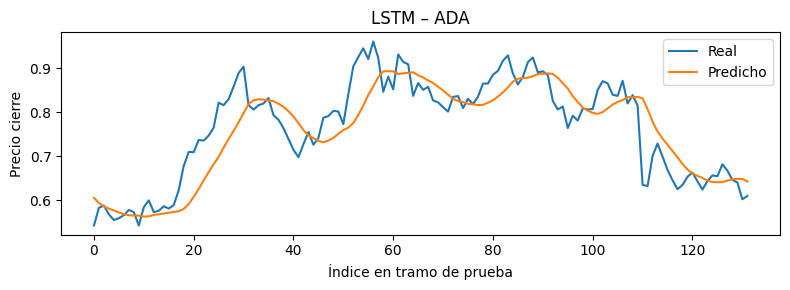

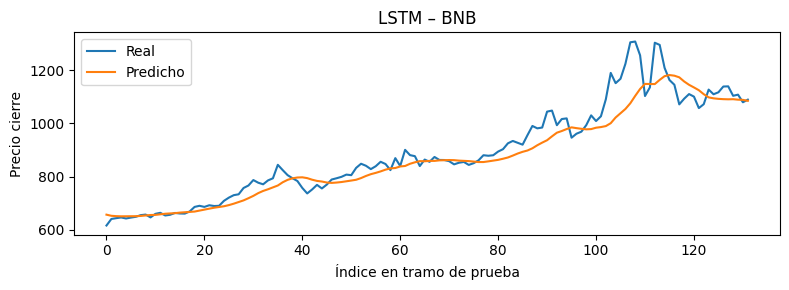

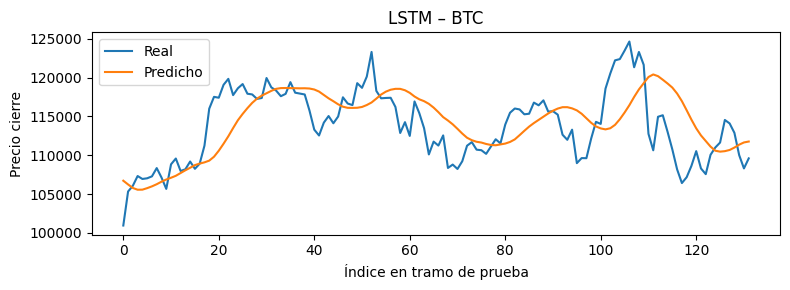

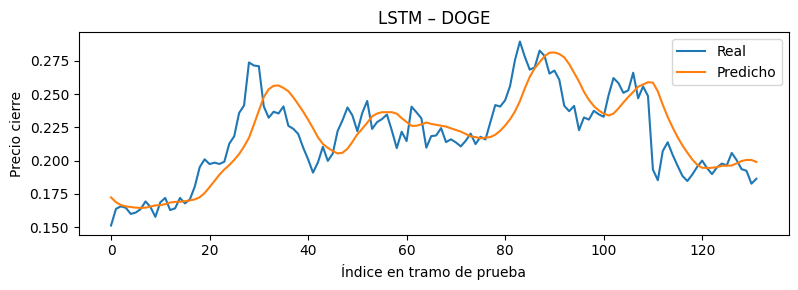

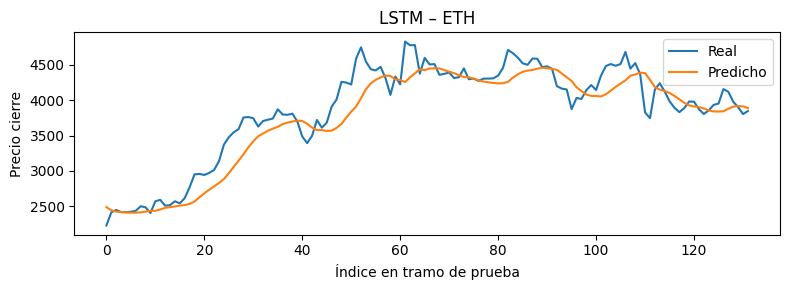

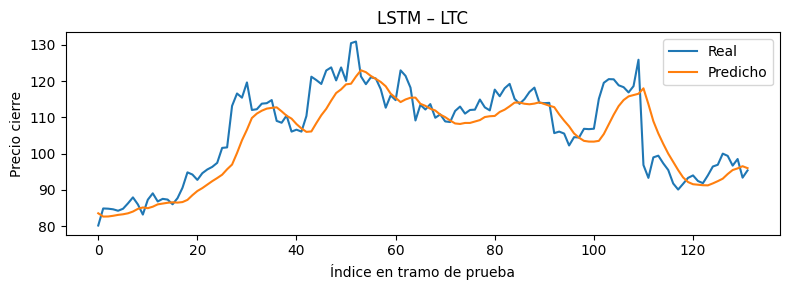

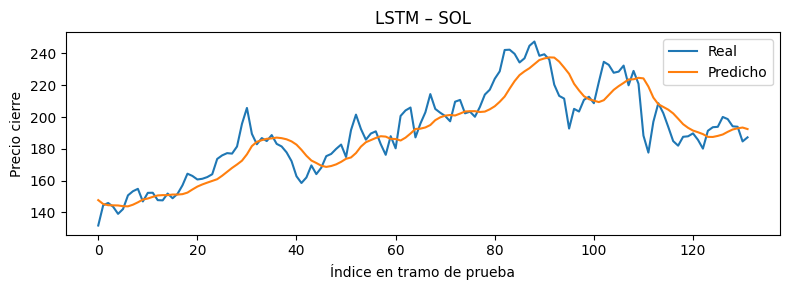

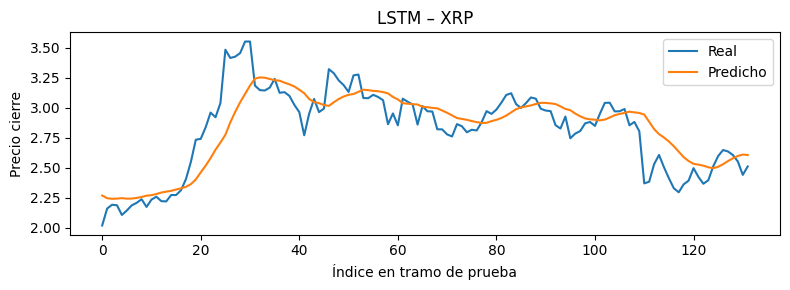

,rmse,mae,mape
ada,0.057632,0.043206,5.637522
bnb,55.730096,36.948633,3.763402
btc,4049.926963,3130.882498,2.751019
doge,0.019426,0.014542,6.568714
eth,249.293415,185.368951,4.775641
ltc,6.044148,4.395756,4.075416
sol,12.137968,9.154001,4.729830
xrp,0.189607,0.138608,4.951588


In [15]:
def crear_supervisado(serie, ventana=14):
    """
    Convierte una serie en un conjunto supervisado:
    ventanas de 'ventana' días -> precio del día siguiente.
    """
    valores = serie.values.reshape(-1, 1)

    escala = MinMaxScaler()
    valores_norm = escala.fit_transform(valores)

    X, y = [], []
    for i in range(len(valores_norm) - ventana):
        X.append(valores_norm[i : i + ventana])
        y.append(valores_norm[i + ventana])

    X = np.array(X)
    y = np.array(y)

    return X, y, escala


def entrenar_lstm(serie, ventana=14, epochs=10, batch_size=16):
    #se quitan NaN
    serie = serie.dropna()

    #construimos el conjunto supervisado
    X, y, escala = crear_supervisado(serie, ventana)

    # 80% train 20% test
    corte = int(len(X) * 0.8)
    X_train, X_test = X[:corte], X[corte:]
    y_train, y_test = y[:corte], y[corte:]

    #modelo lstm
    modelo = models.Sequential()
    modelo.add(layers.Input(shape=(ventana, 1)))
    modelo.add(layers.LSTM(32))
    modelo.add(layers.Dense(1))

    modelo.compile(optimizer="adam", loss="mse")
    modelo.fit(X_train, y_train, epochs=epochs, batch_size=batch_size, verbose=0)

    #prediccion en tramo de prueba
    y_pred = modelo.predict(X_test, verbose=0)

    #volvemos a escala original
    y_test_inv = escala.inverse_transform(y_test).ravel()
    y_pred_inv = escala.inverse_transform(y_pred).ravel()

    #metricas rmse
    mse  = mean_squared_error(y_test_inv, y_pred_inv)
    rmse = mse ** 0.5
    mae  = mean_absolute_error(y_test_inv, y_pred_inv)
    mape = (np.abs((y_test_inv - y_pred_inv) / y_test_inv)).mean() * 100

    return {"rmse": rmse, "mae": mae, "mape": mape}, y_test_inv, y_pred_inv


metricas_lstm = {}

for coin in wide_close.columns:
    serie = wide_close[coin]

    m, y_real, y_pred = entrenar_lstm(serie, ventana=14, epochs=10, batch_size=16)
    metricas_lstm[coin] = m

    #grafico sencillo de valores reales vs predichos
    plt.figure(figsize=(8, 3))
    plt.plot(y_real, label="Real")
    plt.plot(y_pred, label="Predicho")
    plt.title(f"LSTM – {coin.upper()}")
    plt.xlabel("Índice en tramo de prueba")
    plt.ylabel("Precio cierre")
    plt.legend()
    plt.tight_layout()
    plt.show()

#tabla con metricas de la lstm
pd.DataFrame(metricas_lstm).T


En esta celda se implementa un modelo de red neuronal lstm para predecir el precio de cierre de cada criptomoneda. Primero se convierte la serie de precios en un problema supervisado: se toman ventanas de 14 días consecutivos como entrada y se intenta predecir el precio del día siguiente. Para esto se normalizan los datos entre 0 y 1 con MinMaxScaler. Luego se divide el conjunto en entrenamiento 80 % y prueba 20 % y se construye un modelo sencillo con una sola capa lstm y una capa densa de salida, usando adam y pérdida mse, tal como se ha trabajado en clase. Después de entrenar el modelo, se obtienen las predicciones sobre el tramo de prueba, se vuelven a la escala original y se calculan las métricas de error rmse, mae y mape.Finalmente, para cada moneda se guarda el resultado en un diccionario de métricas y se genera un gráfico donde se comparan los valores reales con los valores predichos por la lstm.

**resultados sprint 2**

In [16]:
metricas_arima = {}
metricas_lstm = {}

for coin, sub in df.groupby("coin"):
    serie = sub.set_index("time")["close"]

    # --- ARIMA ---
    test_precio, pron_precio, met_arima = evaluar_arima_mejor(serie)  # o la función que estés usando
    metricas_arima[coin] = met_arima

    # --- LSTM ---
    model, escala, met_lstm = entrenar_lstm(serie)  # tu función de LSTM
    metricas_lstm[coin] = met_lstm


c:\Users\JuanD\AppData\Local\pypoetry\Cache\virtualenvs\proyecto-crypto-M_LZfFhF-py3.11\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
c:\Users\JuanD\AppData\Local\pypoetry\Cache\virtualenvs\proyecto-crypto-M_LZfFhF-py3.11\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
c:\Users\JuanD\AppData\Local\pypoetry\Cache\virtualenvs\proyecto-crypto-M_LZfFhF-py3.11\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
c:\Users\JuanD\AppData\Local\pypoetry\Cache\virtualenvs\proyecto-crypto-M_LZfFhF-py3.11\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided

In [17]:

#resumen con clusters
summary.to_csv("data/cluster_resumen_monedas.csv", index=False)

#metricas de arima
pd.DataFrame(metricas_arima).T.to_csv("data/metricas_arima.csv")

#metricas de lstm
pd.DataFrame(metricas_lstm).T.to_csv("data/metricas_lstm.csv")

print("Archivos guardados en data/:")
print("- cluster_resumen_monedas.csv")
print("- metricas_arima.csv")
print("- metricas_lstm.csv")


Archivos guardados en data/:
- cluster_resumen_monedas.csv
- metricas_arima.csv
- metricas_lstm.csv


En esta celda se guardan los resultados del Sprint 2 en archivos CSV dentro de la carpeta data, para dejar todo listo para los siguientes sprints y para el informe.

Se exporta la tabla summary, que contiene las estadísticas por moneda y los clusters obtenidos con K-Means, DBSCAN y el modelo jerárquico, al archivo cluster_resumen_monedas.csv.

Se convierten los diccionarios metricas_arima y metricas_lstm en dataframes y se guardan en metricas_arima.csv y metricas_lstm.csv.
Estos archivos almacenan las métricas de error de los modelos de predicción para cada criptomoneda.